# Voltage control

In [ ]:
import os.path
import time
import random
import csv
import array
import math
import numpy as np
import pandas as pd
import scipy
import scipy.io
import cvxpy as cp
from joblib import Parallel, delayed
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypower.api import ext2int, int2ext, makeYbus

class VoltageControl:
    def __init__(self, path, test_case, optimization_method):
        self.PATH = path
        self.TEST_CASE = test_case
        self.OPTIMIZATION_METHOD = optimization_method

    def load_mat(self):
        mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
        bus = mat['ans']['bus'][0][0]
        baseMVA = mat['ans']['baseMVA'][0][0][0][0]
        gen = mat['ans']['gen'][0][0]
        branch = mat['ans']['branch'][0][0]
        keys = ['baseMVA', 'bus', 'gen', 'branch']
        values = [baseMVA, bus, gen, branch]
        ppc = dict(zip(keys, values))
        ppc = ext2int(ppc)
        baseMVA, bus, gen, branch = ppc['baseMVA'], ppc['bus'], ppc['gen'], ppc['branch']
        Ybus, Yf, Yt = makeYbus(baseMVA, bus, branch)
        return baseMVA, bus, gen, branch, Ybus, Yf, Yt, ppc

    def process_bus_and_gen(self, bus, gen, baseMVA, branch, ppc):
        Just_load = bus[np.logical_or(bus[:, 2] != 0, bus[:, 3] != 0)]
        load_buses = Just_load[:, 0]
        load_buses = np.reshape(load_buses, (len(load_buses), 1))
        n_buses = len(ppc['bus'])
        n_gens = len(ppc['gen'])
        n_branches = len(ppc['branch'])
        r = branch[:, 2]
        x = branch[:, 3]
        ref_bus = np.where(bus[:, 1] == 3)[0][0]
        return load_buses, n_buses, n_gens, n_branches, r, x, ref_bus

    def compute_incidence_matrix(self, n_buses, n_branches, branch, ref_bus):
        """Compute the incidence matrix"""
        A = np.zeros((n_buses, n_branches))
        from_bus = branch[:, 0].astype(int)
        to_bus = branch[:, 1].astype(int)
        A[from_bus, np.arange(n_branches)] = 1
        A[to_bus, np.arange(n_branches)] = -1
        A = np.delete(A, ref_bus, axis=0)
        A = A.T
        return A

    def convert_branch(self, baseMVA, bus, branch):
        """Convert branch values (r and x) if the .m file is not in per unit format"""
        Vbase = bus[0, 9] * 1e3  # Vbase = mpc.bus(1, BASE_KV) * 1e3; in Volts
        Sbase = baseMVA * 1e6  # Sbase = mpc.baseMVA * 1e6; in VA
        branch[:, [2, 3]] = branch[:, [2, 3]] / (Vbase ** 2 / Sbase)  # convert branch impedance

    def load_and_process_data(self):
        baseMVA, bus, gen, branch, Ybus, Yf, Yt, ppc = self.load_mat()
        load_buses, n_buses, n_gens, n_branches, r, x, ref_bus = self.process_bus_and_gen(bus, gen, baseMVA, branch, ppc)
        A = self.compute_incidence_matrix(n_buses, n_branches, branch, ref_bus)
        F = np.linalg.inv(A)
        connected_bus_to_ref = int(branch[branch[:, 0] == ref_bus][:, 1][0] - 1)
        Pd = bus[1:, 2] / (1000 * baseMVA)
        Qd = bus[1:, 3] / (1000 * baseMVA)
        self.convert_branch(baseMVA, bus, branch)
        r = branch[:, 2]
        x = branch[:, 3]
        return baseMVA, bus, gen, branch, Ybus, Yf, Yt, ppc, load_buses, n_buses, n_gens, n_branches, r, x, ref_bus, F, connected_bus_to_ref, Pd, Qd

    def optimize(self):
        baseMVA, bus, gen, branch, Ybus, Yf, Yt, ppc, load_buses, n_buses, n_gens, n_branches, r, x, ref_bus, F, connected_bus_to_ref, Pd, Qd = self.load_and_process_data()

        """Cold-start parameters"""
        Dr = r
        Dx = x
        gamma_P = np.zeros(n_buses - 1)
        gamma_Q = np.zeros(n_buses - 1)
        bias = np.zeros(n_buses - 1)

        """Optimized parameters"""
        Dr = np.loadtxt(f"{self.PATH}/parameters/Dr_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
        Dx = np.loadtxt(f"{self.PATH}/parameters/Dx_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
        gamma_P = np.loadtxt(f"{self.PATH}/parameters/gamma_P_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
        gamma_Q = np.loadtxt(f"{self.PATH}/parameters/gamma_Q_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
        bias = np.loadtxt(f"{self.PATH}/parameters/bias_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

        S_PV_Gen = 0.6 * np.ones(n_buses - 1)
        S_PV_Gen = np.array(S_PV_Gen) / baseMVA
        S_PV_Gen = S_PV_Gen.reshape(-1, 1)
        S_PV_Gen = np.reshape(S_PV_Gen, (n_buses - 1,))
        P_PV_Gen = 0.98 * S_PV_Gen
        Q_PV_Gen = (S_PV_Gen ** 2 - P_PV_Gen ** 2) ** 0.5

        """Variables"""
        p = cp.Variable(n_buses - 1)
        q = cp.Variable(n_buses - 1)
        P_slack = cp.Variable(1)
        Q_slack = cp.Variable(1)

        """Min and Max voltages"""
        V_min = (0.95 ** 2) * np.ones(n_buses - 1)
        V_max = (1.05 ** 2) * np.ones(n_buses - 1)

        objective = cp.Minimize(cp.sum_squares((P_PV_Gen - p) / P_PV_Gen) + 0.02 * cp.sum_squares(q / S_PV_Gen))

        I = np.reshape(np.ones(n_buses - 1), (n_buses - 1,))
        v = I + 2 * F @ np.multiply(Dr, F.T) @ (p - Pd + gamma_P) + 2 * F @ np.multiply(Dx, F.T) @ (q - Qd + gamma_Q) + bias

        constraints = [
            0 <= p,
            P_PV_Gen >= p,
            -Q_PV_Gen <= q,
            Q_PV_Gen >= q,
            p ** 2 + q ** 2 <= S_PV_Gen ** 2,
            -1 <= P_slack, P_slack <= 1,
            P_slack == -I.T @ (p - Pd + gamma_P),
            Q_slack == -I.T @ (q - Qd + gamma_Q),
            V_min <= v,
            V_max >= v,
            F.T @ (p - Pd + gamma_P) <= 4 * np.ones(n_buses - 1),
            F.T @ (p - Pd + gamma_P) >= -4 * np.ones(n_buses - 1),
            F.T @ (q - Qd + gamma_Q) <= 3 * np.ones(n_buses - 1),
            F.T @ (q - Qd + gamma_Q) >= -3 * np.ones(n_buses - 1)
        ]

        prob = cp.Problem(objective, constraints)
        result = prob.solve()

        V = (v.value) ** 0.5
        print(f"Total PV Gen: {np.sum(p.value)}")
        print("-----------------------------------------------")
        print("Objective function:\n", result)
        print("-----------------------------------------------")
        print("Voltage magnitude:\n", V)
        print("-----------------------------------------------")
        print("Active PV generation: \n", p.value)
        print("-----------------------------------------------")
        print("Reactive PV generation:\n", q.value)
        print("-----------------------------------------------")
        print("Slack bus:\n", P_slack.value)
        print("-----------------------------------------------")

        np.savetxt(f"{self.PATH}/parameters/Voltage_OLDF__{self.TEST_CASE}.txt", V)
        np.savetxt(f"{self.PATH}/parameters/OLDF_P_PV_{self.TEST_CASE}.txt", p.value)
        np.savetxt(f"{self.PATH}/parameters/OLDF_Q_PV_{self.TEST_CASE}.txt", q.value)

if __name__ == "__main__":
    optimizer = VoltageControl('/Users/babaktaheri/Desktop/OLDF/Single-phase', '33', 'TNC')
    optimizer.optimize()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


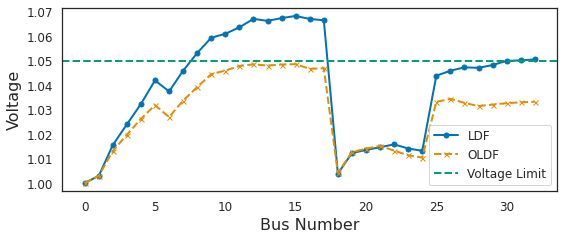

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class VoltageProfilePlotter:
    def __init__(self, test_case, path):
        self.TEST_CASE = test_case
        self.PATH = path
        self.palette = sns.color_palette("colorblind", 4)  # A colorblind-friendly palette

    def load_data(self):
        V_LDF = np.loadtxt(f"{self.PATH}/results/HC_LDF_{self.TEST_CASE}bus.txt")
        V_OLDF = np.loadtxt(f"{self.PATH}/results/HC_OLDF_{self.TEST_CASE}bus.txt")
        V_DF = np.loadtxt(f"{self.PATH}/results/HC_DF_{self.TEST_CASE}bus.txt")
        return V_LDF, V_OLDF, V_DF

    def plot_voltage_profile(self, V_LDF, V_OLDF, V_DF):
        plt.figure(figsize=(8, 3.5))

        # Plot with the selected color palette
        plt.plot(V_LDF, label='LDF', linewidth=2, linestyle='-', marker='o', markersize=5, color=self.palette[0])
        plt.plot(V_OLDF, label='OLDF', linewidth=2, linestyle='--', marker='x', markersize=5, color=self.palette[1])
        #plt.plot(V_DF, label='DF', linewidth=2, linestyle='--', marker='>', markersize=5, color=self.palette[2])

        # Emphasize the standard voltage limit with a contrasting color
        plt.axhline(y=1.05, color=self.palette[2], linestyle='--', linewidth=2, label='Voltage Limit')

        plt.xlabel('Bus Number', fontsize=16)
        plt.ylabel('Voltage', fontsize=16)
        plt.legend(fontsize=12, loc='best')

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.tight_layout()

        plt.savefig("Figs/HC.eps", format='eps', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    sns.set(style="white")  # Set the seaborn style for better aesthetics

    plotter = VoltageProfilePlotter('33', '/Users/babaktaheri/Desktop/OLDF/Single-phase')
    V_LDF, V_OLDF, V_DF = plotter.load_data()
    plotter.plot_voltage_profile(V_LDF, V_OLDF, V_DF)
